<a href="https://colab.research.google.com/github/villasen/colab_notebooks/blob/master/Keras_train_for_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/villasen/speech-numpy.git

Cloning into 'speech-numpy'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (39/39), done.
Checking out files: 100% (32/32), done.


In [6]:
import keras
from keras import layers
from keras import models
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import librosa
import tensorflow
import scipy
import os, shutil
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import urllib
import sys
import tarfile

Using TensorFlow backend.


In [0]:
dest_directory = "/content/speech_target/"
data_url='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'

In [4]:
!ls -al speech-numpy/

total 365972
drwxr-xr-x 2 root root     4096 May 30 05:33 .
drwxr-xr-x 1 root root     4096 May 30 05:30 ..
-rw-r--r-- 1 root root  6789248 May 30 05:32 backward.npy
-rw-r--r-- 1 root root  8217248 May 30 05:32 bed.npy
-rw-r--r-- 1 root root  8421248 May 30 05:32 bird.npy
-rw-r--r-- 1 root root  8286608 May 30 05:32 cat.npy
-rw-r--r-- 1 root root  8682368 May 30 05:32 dog.npy
-rw-r--r-- 1 root root 15981488 May 30 05:32 down.npy
-rw-r--r-- 1 root root 15451088 May 30 05:32 eight.npy
-rw-r--r-- 1 root root  6442448 May 30 05:32 follow.npy
-rw-r--r-- 1 root root  6352688 May 30 05:32 forward.npy
-rw-r--r-- 1 root root 15210368 May 30 05:32 four.npy
-rw-r--r-- 1 root root 15830528 May 30 05:32 go.npy
-rw-r--r-- 1 root root  8621168 May 30 05:32 house.npy
-rw-r--r-- 1 root root  6426128 May 30 05:32 learn.npy
-rw-r--r-- 1 root root 15508208 May 30 05:32 left.npy
-rw-r--r-- 1 root root  8568128 May 30 05:32 marvin.npy
-rw-r--r-- 1 root root 16050848 May 30 05:32 nine.npy
-rw-r--r-- 1 root r

In [0]:
!rm -r speech-numpy/.ipynb_checkpoints/
!rm -r speech-numpy/.git/

In [0]:

data_url='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
os.makedirs(dest_directory)
filename = data_url.split('/')[-1]
filepath = os.path.join(dest_directory, filename)

print(filename)
print(filepath)
 
def _progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' % \
            (filename, float(count * block_size) / float(total_size) * 100.0)) 
    sys.stdout.flush()

urban_dataset_dir = '/content/combined_datasets/' 

In [0]:
  def maybe_download_and_extract_dataset(data_url, dest_directory):
    """Download and extract data set tar file.
    If the data set we're using doesn't already exist, this function
    downloads it from the TensorFlow.org website and unpacks it into a
    directory.
    If the data_url is none, don't download anything and expect the data
    directory to contain the correct files already.
    Args:
      data_url: Web location of the tar file containing the data set.
      dest_directory: File path to extract data to.
    """
    if not data_url:
      return
    if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
    filename = data_url.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    print(filepath)
    if not os.path.exists(filepath):

      def _progress(count, block_size, total_size):
        sys.stdout.write(
            '\r>> Downloading %s %.1f%%' %
            (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()

      try:
        filepath, _ = urllib.request.urlretrieve(data_url, filepath, _progress)
      except:
        tf.logging.error('Failed to download URL: %s to folder: %s', data_url,
                         filepath)
        tf.logging.error('Please make sure you have enough free space and'
                         ' an internet connection')
        raise
      print()
      statinfo = os.stat(filepath)
      tf.logging.info('Successfully downloaded %s (%d bytes)', filename,
                      statinfo.st_size)
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [0]:
maybe_download_and_extract_dataset( data_url, dest_directory)

In [0]:
!ls speech_target/ -al

In [7]:
labels = os.listdir('speech-numpy/')
print(labels)

['wow.npy', 'go.npy', 'left.npy', 'on.npy', 'three.npy', 'dog.npy', 'backward.npy', 'stop.npy', 'learn.npy', 'visual.npy', 'two.npy', 'bird.npy', 'off.npy', 'tree.npy', 'house.npy', 'cat.npy', 'down.npy', 'four.npy', 'eight.npy', 'nine.npy', 'follow.npy', 'marvin.npy', 'zero.npy', 'up.npy', 'no.npy', 'sheila.npy', 'right.npy', 'forward.npy', 'bed.npy', 'six.npy', 'yes.npy']


In [0]:
def get_train_test(split_ratio=0.9, random_state=42):
    # Get available labels
    #labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    #X = np.load('/content/target_npy_files/' + labels[0] + '.npy')
    X = np.load('/content/speech-numpy/' + labels[0])
    y = np.zeros(X.shape[0])

    
    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        #x = np.load('/content/target_npy_files/' + label + '.npy')
        x = np.load('/content/speech-numpy/' + label)
        
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [0]:
#save_data_to_array(path=DATA_PATH, max_pad_len=51)    
X_train, X_test, y_train, y_test = get_train_test()

X_train = X_train.reshape(X_train.shape[0], 10, 51, 1)
X_test = X_test.reshape(X_test.shape[0], 10, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [0]:
!rm -r target_model/


Train on 82651 samples, validate on 9184 samples
Epoch 1/20
82651/82651 [==============================] - 16s 192us/step - loss: 3.0969 - acc: 0.0852 - val_loss: 3.1185 - val_acc: 0.0818
Epoch 2/20
82651/82651 [==============================] - 14s 175us/step - loss: 2.7703 - acc: 0.1339 - val_loss: 2.6588 - val_acc: 0.1725
Epoch 3/20
82651/82651 [==============================] - 14s 166us/step - loss: 2.4234 - acc: 0.2174 - val_loss: 2.0929 - val_acc: 0.3398
Epoch 4/20
82651/82651 [==============================] - 14s 165us/step - loss: 2.0176 - acc: 0.3522 - val_loss: 1.6953 - val_acc: 0.4594
Epoch 5/20
82651/82651 [==============================] - 14s 166us/step - loss: 1.7309 - acc: 0.4497 - val_loss: 1.4475 - val_acc: 0.5444
Epoch 6/20
82651/82651 [==============================] - 14s 168us/step - loss: 1.5465 - acc: 0.5164 - val_loss: 1.2288 - val_acc: 0.6287
Epoch 7/20
82651/82651 [==============================] - 14s 169us/step - loss: 1.4098 - acc: 0.5628 - val_loss: 1.0

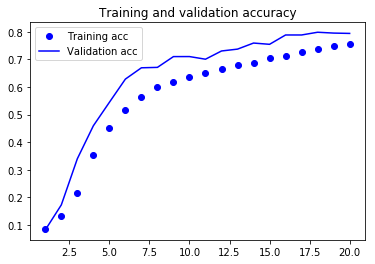

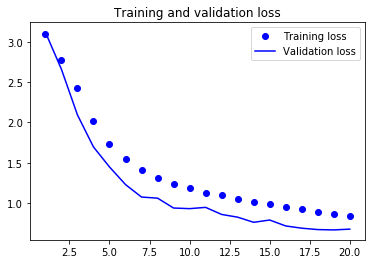

In [13]:
# Creating Keras sequential model
#bn = 1
target_model = '/content/target_model/'
os.mkdir(target_model)
BN=True
model = models.Sequential()

def dscnn_train():
  # 1
      model.add(layers.Conv2D(64, (4,10), strides=(2,2), padding='same', activation='relu', \
                #input_shape=(10, 49, 1)))
                input_shape=(10,51,1)))
      #model.add(layers.Dropout(0.5))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                                center=True, scale=True, beta_initializer='zeros', \
                                                gamma_initializer='ones', moving_mean_initializer='zeros', \
                                                moving_variance_initializer='ones', beta_regularizer=None, \
                                                gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      #model.add(layers.Dropout(0.5))
      # 2
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))  
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      #model.add(layers.Dropout(0.5))

      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
     # model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
     # model.add(layers.Dropout(0.5))
      # 3
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
     # model.add(layers.Dropout(0.5))
      
      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))

      # 4
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))
      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))

      # 5
      model.add(layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu'))
      if BN == True:
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))
      model.add(layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False))
      if BN == True:      
          model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, \
                                              center=True, scale=True, beta_initializer='zeros', \
                                              gamma_initializer='ones', moving_mean_initializer='zeros', \
                                              moving_variance_initializer='ones', beta_regularizer=None, \
                                              gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
      #model.add(layers.Dropout(0.5))
      model.add(layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
      model.add(layers.Dropout(0.5))


      
           
      
# Final layer
      
      #model.add(layers.Dropout(0.5))
      model.add(layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None))
      model.add(layers.Dropout(0.5))
      model.add(layers.Flatten(data_format=None))
     # model.add(layers.Dropout(0.5))
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dropout(0.5))
      #model.add(layers.Dense(12, activation='softmax'))
      model.add(layers.Dense(31, activation='softmax'))
      #model.add(layers.Dropout(0.5))
      # Compilation step to choose loss function, optimizer and metric
      # Configuring the learning process
      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
      #model.fit()
      history = model.fit(X_train, y_train_hot, batch_size=100, epochs=20, verbose=1, validation_data=(X_test, y_test_hot))
      
      #plt.plot(history.history['acc'])
      #Restarts layer sequence number 
      #K.clear_session()

      acc = history.history['acc']
      val_acc = history.history['val_acc']
      loss = history.history['loss']
      val_loss = history.history['val_loss']
      epochs = range(1, len(acc) + 1)
      
      plt.plot(epochs, acc, 'bo', label='Training acc')
      plt.plot(epochs, val_acc, 'b', label='Validation acc')
      plt.title('Training and validation accuracy')
      plt.legend()

      plt.figure()

      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs,val_loss, 'b', label='Validation loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()
      
      
      model.save('/content/target_model/urban_sound.h5')
  
dscnn_train()  